<a href="https://colab.research.google.com/github/cwjng/si670-final-project/blob/main/si670_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Git repo to clone
# git clone https://github.com/cwjng/si670-final-project.git

In [26]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [12]:
cmr_df = pd.read_csv("si670-final-project/cancer_mortality_rates.csv")
cmr_df.head()

,cmRate,population,medianIncome,pctPoverty,avgHouse,medianAge,medianAgeM,medianAgeF,pctHS,pctBach,...,pctBlack,pctAsian,pctOther,rmRace,pctMarried,pctMarriedHouse,birthRate,region,state,county
0,191.2,25859,38013,18.6,2.28,45.4,44.6,46.2,36.4,7.9,...,4.925408,0.338357,0.065365,white,62.1,57.173258,4.687790,Southeast,Alabama,Cherokee County
1,187.9,82005,39922,17.2,2.55,40.5,39.4,41.9,34.7,9.1,...,1.190638,0.557031,0.737356,white,57.6,54.850257,3.913309,Southeast,Alabama,Cullman County
2,217.4,41131,26602,35.2,2.53,38.7,36.2,40.0,34.6,8.2,...,69.184419,0.341605,0.161313,black,33.4,30.987632,8.433257,Southeast,Alabama,Dallas County
3,193.8,81468,54298,14.4,2.65,37.9,36.7,39.1,35.4,13.4,...,21.218875,0.516326,0.678529,white,51.0,54.326202,5.800147,Southeast,Alabama,Elmore County
4,205.8,16759,35664,20.6,2.36,43.2,41.3,46.1,38.8,8.4,...,12.387547,0.390625,0.000000,white,53.6,51.499218,5.730897,Southeast,Alabama,Fayette County


In [13]:
cmr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cmRate           537 non-null    float64
 1   population       537 non-null    int64  
 2   medianIncome     537 non-null    int64  
 3   pctPoverty       537 non-null    float64
 4   avgHouse         537 non-null    float64
 5   medianAge        537 non-null    float64
 6   medianAgeM       537 non-null    float64
 7   medianAgeF       537 non-null    float64
 8   pctHS            537 non-null    float64
 9   pctBach          537 non-null    float64
 10  pctEmployed      537 non-null    float64
 11  pctUnemployed    537 non-null    float64
 12  pctPrivateHC     537 non-null    float64
 13  pctEmployerHC    537 non-null    float64
 14  pctPublicHC      537 non-null    float64
 15  pctWhite         537 non-null    float64
 16  pctBlack         537 non-null    float64
 17  pctAsian        

In [14]:
cmr_df["cmRate"].describe()

,cmRate
count,537.000000
mean,178.993110
std,27.320395
min,94.400000
25%,161.400000
50%,177.800000
75%,195.500000
max,293.900000


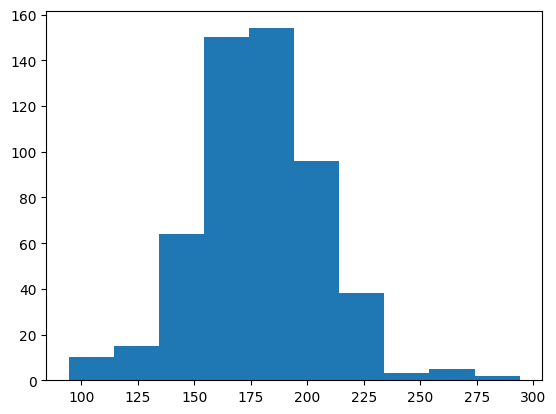

In [15]:
plt.hist(cmr_df["cmRate"]) # Normal distribution
plt.show()

In [16]:
def categorize_cmrates(rate, q1, median, q3):
  if rate < q1:
    return "Low"
  elif rate < median:
    return "Medium"
  return "High"

quartile_1 = cmr_df["cmRate"].quantile(0.25)
median = cmr_df["cmRate"].quantile(0.5)
quartile_3 = cmr_df["cmRate"].quantile(0.75)

cmr_df["cmClass"] = cmr_df["cmRate"].apply(lambda x: categorize_cmrates(x, quartile_1,
                                                                               median, quartile_3))
cmr_df.head()

,cmRate,population,medianIncome,pctPoverty,avgHouse,medianAge,medianAgeM,medianAgeF,pctHS,pctBach,...,pctAsian,pctOther,rmRace,pctMarried,pctMarriedHouse,birthRate,region,state,county,cmClass
0,191.2,25859,38013,18.6,2.28,45.4,44.6,46.2,36.4,7.9,...,0.338357,0.065365,white,62.1,57.173258,4.687790,Southeast,Alabama,Cherokee County,High
1,187.9,82005,39922,17.2,2.55,40.5,39.4,41.9,34.7,9.1,...,0.557031,0.737356,white,57.6,54.850257,3.913309,Southeast,Alabama,Cullman County,High
2,217.4,41131,26602,35.2,2.53,38.7,36.2,40.0,34.6,8.2,...,0.341605,0.161313,black,33.4,30.987632,8.433257,Southeast,Alabama,Dallas County,High
3,193.8,81468,54298,14.4,2.65,37.9,36.7,39.1,35.4,13.4,...,0.516326,0.678529,white,51.0,54.326202,5.800147,Southeast,Alabama,Elmore County,High
4,205.8,16759,35664,20.6,2.36,43.2,41.3,46.1,38.8,8.4,...,0.390625,0.000000,white,53.6,51.499218,5.730897,Southeast,Alabama,Fayette County,High


In [17]:
cmr_df["cmClass"].value_counts()

,count
cmClass,
High,269
Medium,134
Low,134


In [18]:
X = cmr_df.drop(columns=["cmRate", "cmClass"])
y = cmr_df["cmClass"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

In [23]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
log_clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(
        multi_class="multinomial",
        max_iter=2000
    ))
])

log_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['population', 'medianIncome', 'pctPoverty', 'avgHouse', 'medianAge',
       'medianAgeM', 'medianAgeF', 'pctHS', 'pctBach', 'pctEmployed',
       'pctUnemployed', 'pctPrivateHC', 'pctEmployerHC', 'pctPublicHC',
       'pctWhite', 'pctBlack', 'pctAsian', 'pctOther', 'pctMarried',
       'pctMarriedHouse', 'birthRate'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['rmRace', 'region', 'state', 'county'], dtype='object'))])),
                ('model',
                 LogisticRegression(max_iter=2000, multi_class='multinomial'))])

In [28]:
rf_clf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['population', 'medianIncome', 'pctPoverty', 'avgHouse', 'medianAge',
       'medianAgeM', 'medianAgeF', 'pctHS', 'pctBach', 'pctEmployed',
       'pctUnemployed', 'pctPrivateHC', 'pctEmployerHC', 'pctPublicHC',
       'pctWhite', 'pctBlack', 'pctAsian', 'pctOther', 'pctMarried',
       'pctMarriedHouse', 'birthRate'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['rmRace', 'region', 'state', 'county'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(n_estimators=400, random_state=42))])

In [29]:
gb_clf = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(
        random_state=42
    ))
])

gb_clf.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['population', 'medianIncome', 'pctPoverty', 'avgHouse', 'medianAge',
       'medianAgeM', 'medianAgeF', 'pctHS', 'pctBach', 'pctEmployed',
       'pctUnemployed', 'pctPrivateHC', 'pctEmployerHC', 'pctPublicHC',
       'pctWhite', 'pctBlack', 'pctAsian', 'pctOther', 'pctMarried',
       'pctMarriedHouse', 'birthRate'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['rmRace', 'region', 'state', 'county'], dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [30]:
svm_clf = Pipeline([
    ("prep", preprocess),
    ("model", SVC(
        kernel="rbf",
        probability=True
    ))
])

svm_clf.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['population', 'medianIncome', 'pctPoverty', 'avgHouse', 'medianAge',
       'medianAgeM', 'medianAgeF', 'pctHS', 'pctBach', 'pctEmployed',
       'pctUnemployed', 'pctPrivateHC', 'pctEmployerHC', 'pctPublicHC',
       'pctWhite', 'pctBlack', 'pctAsian', 'pctOther', 'pctMarried',
       'pctMarriedHouse', 'birthRate'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['rmRace', 'region', 'state', 'county'], dtype='object'))])),
                ('model', SVC(probability=True))])

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_clf = Pipeline([
    ("prep", preprocess),
    ("model", KNeighborsClassifier(
        n_neighbors=7,        # You can tune this
        weights="distance"    # distance weighting often improves performance
    ))
])

knn_clf.fit(X_train, y_train)


=== KNN Classifier ===
Accuracy: 0.5648148148148148
Macro F1: 0.5069786480510062
Weighted F1: 0.5572251364807326

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.74      0.71        54
         Low       0.56      0.52      0.54        27
      Medium       0.29      0.26      0.27        27

    accuracy                           0.56       108
   macro avg       0.51      0.51      0.51       108
weighted avg       0.55      0.56      0.56       108



In [31]:
models = {
    "Logistic Regression": log_clf,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
    "SVM (RBF)": svm_clf,
    "KNN": knn_clf
}

for name, model in models.items():
    preds = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Macro F1:", f1_score(y_test, preds, average="macro"))
    print("Weighted F1:", f1_score(y_test, preds, average="weighted"))
    print(classification_report(y_test, preds))


=== Logistic Regression ===
Accuracy: 0.6111111111111112
Macro F1: 0.5592776809757644
Weighted F1: 0.6063741485822904
              precision    recall  f1-score   support

        High       0.75      0.74      0.75        54
         Low       0.56      0.67      0.61        27
      Medium       0.35      0.30      0.32        27

    accuracy                           0.61       108
   macro avg       0.56      0.57      0.56       108
weighted avg       0.60      0.61      0.61       108


=== Random Forest ===
Accuracy: 0.6574074074074074
Macro F1: 0.5813155770782888
Weighted F1: 0.6309019370460048
              precision    recall  f1-score   support

        High       0.72      0.85      0.78        54
         Low       0.66      0.70      0.68        27
      Medium       0.40      0.22      0.29        27

    accuracy                           0.66       108
   macro avg       0.59      0.59      0.58       108
weighted avg       0.62      0.66      0.63       108


=== G

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Wrap preprocess + RandomForest into a single pipeline
rf_pipeline = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid to search
param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", None]
}

# GridSearchCV with 5-fold CV, optimizing macro-F1
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['population', 'medianIncome', 'pctPoverty', 'avgHouse', 'medianAge',
       'medianAgeM', 'medianAgeF', 'pctHS', 'pctBach', 'pctEmployed',
       'pctUnemployed', 'pctPrivateHC', 'pctEmployerHC', 'pctPublicHC',
       'pctWhite', 'pctBlack', 'pctAsian', 'pctOther', 'pctMarr...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['rmRace', 'region', 'state', 'county'], dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20],
                         'model__max_features': ['sqrt', None],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [200, 400]},
             scoring='f1_macro', verbose=2)

In [44]:
best_rf = grid_search.best_estimator_
best_preds = best_rf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("=== Best Random Forest (Reduced Grid) ===")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, best_preds))
print("Macro F1:", f1_score(y_test, best_preds, average="macro"))
print("Weighted F1:", f1_score(y_test, best_preds, average="weighted"))
print("\nClassification Report:")
print(classification_report(y_test, best_preds))


=== Best Random Forest (Reduced Grid) ===
Best Parameters: {'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Accuracy: 0.6111111111111112
Macro F1: 0.5351721324160441
Weighted F1: 0.5867239268982399

Classification Report:
              precision    recall  f1-score   support

        High       0.69      0.80      0.74        54
         Low       0.60      0.67      0.63        27
      Medium       0.31      0.19      0.23        27

    accuracy                           0.61       108
   macro avg       0.54      0.55      0.54       108
weighted avg       0.57      0.61      0.59       108



In [37]:
!pip install xgboost --quiet  # only if not installed

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_clf = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

xgb_clf.fit(X_train, y_train)

# Predictions
xgb_preds = xgb_clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print("=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Macro F1:", f1_score(y_test, xgb_preds, average="macro"))
print("Weighted F1:", f1_score(y_test, xgb_preds, average="weighted"))
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds))


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['High' 'Low' 'Medium']

In [42]:
!pip install lightgbm --quiet  # only if not installed

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

lgbm_clf = Pipeline([
    ("prep", preprocess),
    ("model", LGBMClassifier(
        n_estimators=500,
        max_depth=-1,
        learning_rate=0.1,
        random_state=42
    ))
])

lgbm_clf.fit(X_train, y_train)

# Predictions
lgbm_preds = lgbm_clf.predict(X_test)

print("=== LightGBM Classifier ===")
print("Accuracy:", accuracy_score(y_test, lgbm_preds))
print("Macro F1:", f1_score(y_test, lgbm_preds, average="macro"))
print("Weighted F1:", f1_score(y_test, lgbm_preds, average="weighted"))
print("\nClassification Report:")
print(classification_report(y_test, lgbm_preds))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 30
[LightGBM] [Info] Start training from score -0.690819
[LightGBM] [Info] Start training from score -1.388628
[LightGBM] [Info] Start training from score -1.388628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
